## Causal inference results visualisation

In [46]:
#data modules
import pandas as pd 
import pickle
import numpy as np

#Visualisation package
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colorbar as mcb

import geopandas as gpd
from adjustText import adjust_text


## Step 1: Load results from Causal_discovery_infernce.ipynb

In [47]:
#load all the CATE from Causal_discovery_infernce.ipynb
CATE_perception = pd.read_csv("../Data/CATE_perception.csv", header = None)
CATE_experience = pd.read_csv("../Data/CATE_experience.csv", header = None)
CATE_resilience = pd.read_csv("../Data/CATE_resilience.csv", header = None)

#also load the dataframe from pickle
df = pd.read_pickle('../Data/df_processed.pkl').reset_index()
colnames = list(df.columns)
#merge to same dataset
df = pd.concat([df,CATE_perception,CATE_experience,CATE_resilience], axis="columns")
colnames = colnames+['CATE_perception','CATE_experience','CATE_resilience']
df.columns = colnames
#estimate ATE: 
ATE_perception = CATE_perception.mean()
ATE_experience = CATE_experience.mean()
ATE_resilience = CATE_resilience.mean()
#make some columns categories instead of numeric
df['IncomePerc']=df['IncomePerc'].astype('category')
df['IncomeBracket']=df['IncomeBracket'].astype('category')
labels=['Poorest 20%','Second 20%','Middle 20%','Fourth 20%','Richest 20%']
# Create new dataframe column with the labels instead of numbers
df["IncomeBracket_cat"] = df["IncomeBracket"].map(dict(zip(range(1,6), labels)))


## Step 2: Analyse distribution of CATE

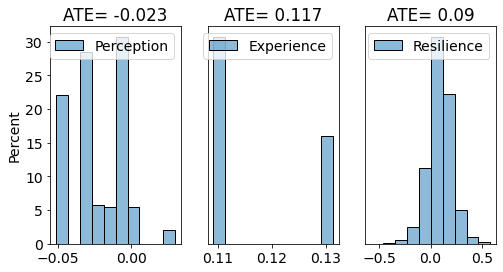

In [48]:
plt.rcParams.update({'font.size': 14})
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,4))
sns.histplot(CATE_perception,bins=10, ax=ax1, color='r', stat='percent', label = 'Perception')
ax1.legend()
ax1.set_title('ATE= -0.023')
sns.histplot(CATE_experience,bins=10, ax=ax2,color='g', stat='percent', label = 'Experience')
ax2.legend()
ax2.set_title('ATE= 0.117')
sns.histplot(CATE_resilience,bins=10, ax=ax3,color='b',stat='percent', label = 'Resilience')
ax3.legend()
ax3.set_title('ATE= 0.09')
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

plt.savefig('../Figures/CATE.pdf')

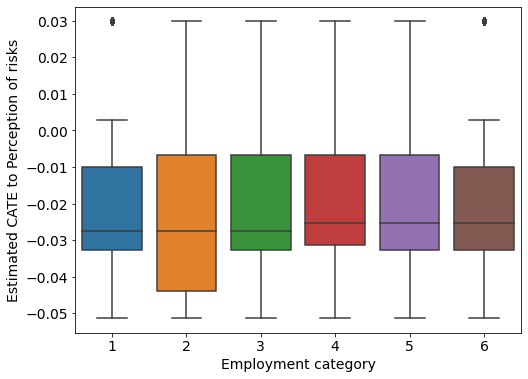

In [49]:
# Assume that cate_estimates is a numpy array or pandas Series of the estimated CATE for each individual
# and df2 is your DataFrame that includes a column 'IncomeBracket' that you want to inspect

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y=df['CATE_perception'], x=df['Employment'])
plt.xlabel('Employment category')
plt.ylabel('Estimated CATE to Perception of risks')
plt.show()


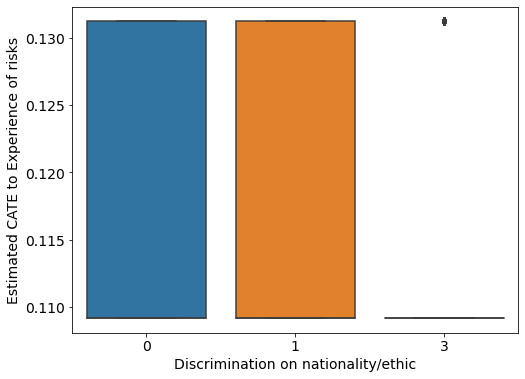

In [50]:
# Assume that cate_estimates is a numpy array or pandas Series of the estimated CATE for each individual
# and df2 is your DataFrame that includes a column 'IncomeBracket' that you want to inspect

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y=df['CATE_experience'], x=df['Dis_ethic'])
plt.xlabel('Discrimination on nationality/ethic')
plt.ylabel('Estimated CATE to Experience of risks')
plt.show()


## Step 2: Plot CATE on a map

First, road the region shapefiles and make some modifications

In [51]:
regions = gpd.read_file("../shapefiles/World_Countries__Generalized_.shp")
regions = regions[regions['COUNTRY'] != 'Antarctica']
regions = regions[['COUNTRY','geometry']]

regions['COUNTRY'] = regions['COUNTRY'].replace('Russian Federation', 'Russia')
regions['COUNTRY'] = regions['COUNTRY'].replace('Bosnia and Herzegovina', 'Bosnia Herzegovina')
regions['COUNTRY'] = regions['COUNTRY'].replace('Congo', 'Congo Brazzaville')
regions['COUNTRY'] = regions['COUNTRY'].replace('Palestinian Territory', 'Palestine')
regions['COUNTRY'] = regions['COUNTRY'].replace('Turkiye', 'Turkey')
regions['COUNTRY'] = regions['COUNTRY'].replace("Côte d'Ivoire", 'Ivory Coast')

regions

globalregion_labels = {
    1: 'Eastern Africa',
    2: 'Central/Western Africa',
    3: 'North Africa',
    4: 'Southern Africa',
    5: 'Latin America & Caribbean',
    6: 'Northern America',
    7: 'Central Asia',
    8: 'East Asia',
    9: 'South-eastern Asia',
    10: 'South Asia',
    11: 'Middle East',
    12: 'Eastern Europe',
    13: 'Northern/Western Europe',
    14: 'Southern Europe',
    15: 'Australia and New Zealand',
}



Now let's merge the geopandas dataframe to the main dataframe

In [52]:
df = df.astype({"Region": int})
df['Country'] = df['Country'].replace('Hong Kong', 'China');
df['Country'] = df['Country'].replace('Taiwan', 'China');
df['Country'] = df['Country'].replace('Kosovo', 'Serbia');

# Replace numerical codes with risk labels using the map() method
df['region_category'] = df['Region'].map(globalregion_labels)
# Merge world data base with Risk Poll data base
df_gpd = regions.merge(df, left_on='COUNTRY', right_on='Country')
#merged = merged.drop(merged[merged['Q2_1'] > 25].index)
df_gpd.head(2)

,COUNTRY,geometry,index,Country,Region,Age,Education,IncomePerc,IncomeBracket,Employment,...,Experience_ind,Resilience_ind,isMale,Employment_binary,IncomePerc_binary,CATE_perception,CATE_experience,CATE_resilience,IncomeBracket_cat,region_category
0,Afghanistan,"POLYGON ((61.27655 35.60725, 61.29638 35.62854...",61757,Afghanistan,10,42,1,4,2,4,...,0.857143,0.0250,1,0,0,-0.025274,0.131245,-0.040223,Second 20%,South Asia
1,Afghanistan,"POLYGON ((61.27655 35.60725, 61.29638 35.62854...",61758,Afghanistan,10,38,1,4,3,4,...,0.785714,0.2125,1,0,0,-0.025274,0.131245,0.270567,Middle 20%,South Asia


Now we can make a new dataframe reprentative to each country

In [53]:
Mean_country = df.groupby('Country').mean().reset_index()
#Mean_country = Mean_country.drop(['Region'], axis=1)
#Mean_country.head(2)

# Replace numerical codes with risk labels using the map() method
Mean_country['region_category'] = Mean_country['Region'].map(globalregion_labels)
# Merge world data base with Risk Poll data base
Mean_country_gpd = regions.merge(Mean_country, left_on='COUNTRY', right_on='Country')
#merged = merged.drop(merged[merged['Q2_1'] > 25].index)
Mean_country_gpd.head(2)

,COUNTRY,geometry,Country,index,Region,Age,Education,Employment,Urbanicity,Child,...,Perception_ind,Experience_ind,Resilience_ind,isMale,Employment_binary,IncomePerc_binary,CATE_perception,CATE_experience,CATE_resilience,region_category
0,Afghanistan,"POLYGON ((61.27655 35.60725, 61.29638 35.62854...",Afghanistan,62271.892446,10.0,31.672215,1.409731,4.724712,1.158771,4.330346,...,0.499517,0.354250,0.309085,0.491677,0.169014,0.156210,-0.025274,0.127683,0.154390,South Asia
1,Albania,"POLYGON ((19.57083 41.68527, 19.58195 41.69569...",Albania,75232.220401,14.0,50.739526,1.732240,4.123862,1.473588,1.500911,...,0.491925,0.073749,0.303473,0.449909,0.333333,0.440801,-0.010022,0.114033,0.093892,Southern Europe


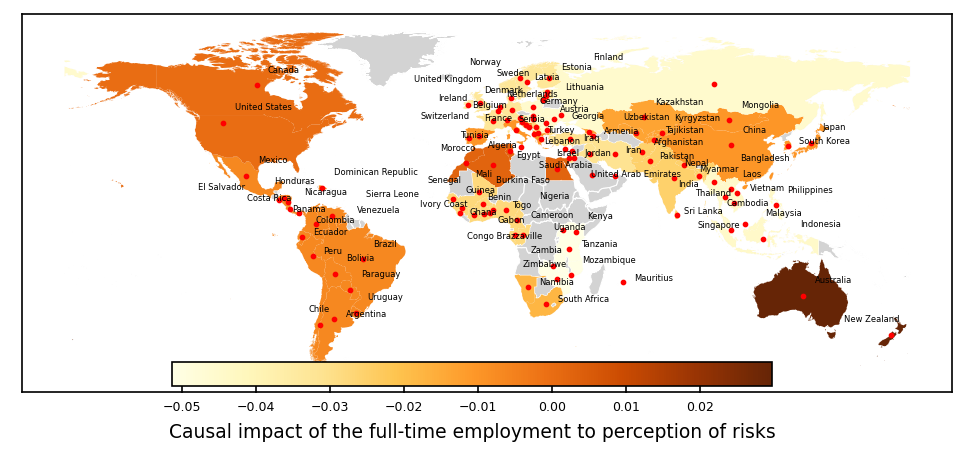

In [54]:

cmap = mpl.cm.YlOrBr
# Set the size of the plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

# Plot the base map in grey color
regions.plot(ax=ax, facecolor='lightgrey', edgecolor='white', linewidth=0.5)

# Remove grids
ax.grid(False)

# Risk frequency
risk_plot = Mean_country_gpd.plot(ax=ax, column='CATE_perception', cmap=cmap, legend=False)

# Create a colorbar within the main graph and make it horizontal
norm = plt.Normalize(Mean_country_gpd['CATE_perception'].min(), Mean_country_gpd['CATE_perception'].max())
cbar_ax = fig.add_axes([0.25, 0.35, 0.5, 0.02])  # Adjust the position and size of the colorbar
cbar = mcb.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.set_xlabel('Causal impact of the full-time employment to perception of risks',fontsize = 9)
cbar.ax.tick_params(labelsize=6)

# Add markers and store annotations in a list
texts = []
for idx, row in Mean_country_gpd.iterrows():
    ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y, s=3, color='red')
    if (row['region_category'] != 'Eastern Europe') &  (row['region_category'] != 'Southern Europe') :
        texts.append(ax.annotate(row['Country'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(5, 5), textcoords='offset points', fontsize=4, color='black'))

# Optimize annotation positions to minimize overlaps
adjust_text(texts, ax=ax,force_text=0.05)

# Hide the x-axis and y-axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
#plt.tight_layout()
plt.savefig('../Figures/CATE_perception.pdf',bbox_inches='tight')
# Show the plot
plt.show()

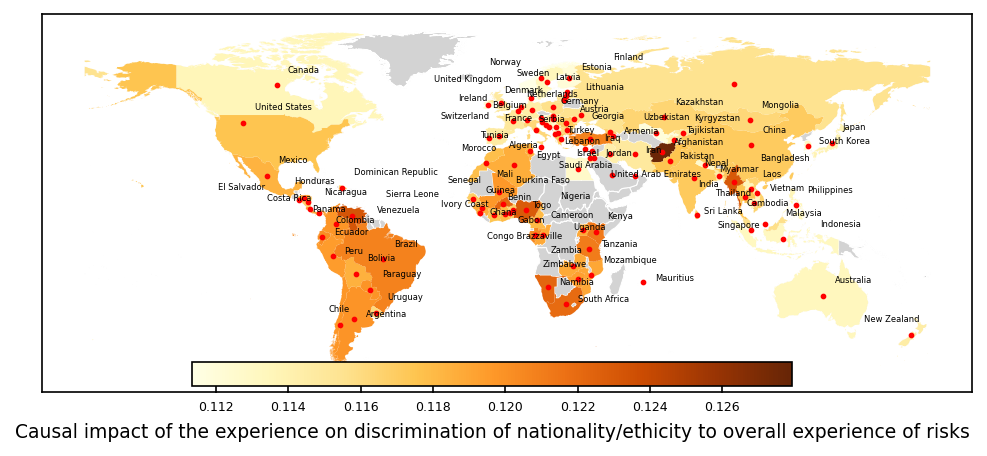

In [55]:

cmap = mpl.cm.YlOrBr
# Set the size of the plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

# Plot the base map in grey color
regions.plot(ax=ax, facecolor='lightgrey', edgecolor='white', linewidth=0.5)

# Remove grids
ax.grid(False)

# Risk frequency
risk_plot = Mean_country_gpd.plot(ax=ax, column='CATE_experience', cmap=cmap, legend=False)

# Create a colorbar within the main graph and make it horizontal
norm = plt.Normalize(Mean_country_gpd['CATE_experience'].min(), Mean_country_gpd['CATE_experience'].max())
cbar_ax = fig.add_axes([0.25, 0.35, 0.5, 0.02])  # Adjust the position and size of the colorbar
cbar = mcb.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.set_xlabel('Causal impact of the experience on discrimination of nationality/ethicity to overall experience of risks',fontsize = 9)
cbar.ax.tick_params(labelsize=6)

# Add markers and store annotations in a list
texts = []
for idx, row in Mean_country_gpd.iterrows():
    ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y, s=3, color='red')
    if (row['region_category'] != 'Eastern Europe') &  (row['region_category'] != 'Southern Europe') :
        texts.append(ax.annotate(row['Country'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(5, 5), textcoords='offset points', fontsize=4, color='black'))

# Optimize annotation positions to minimize overlaps
adjust_text(texts, ax=ax,force_text=0.05)

# Hide the x-axis and y-axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
#plt.tight_layout()
plt.savefig('../Figures/CATE_experience.pdf',bbox_inches='tight')
# Show the plot
plt.show()

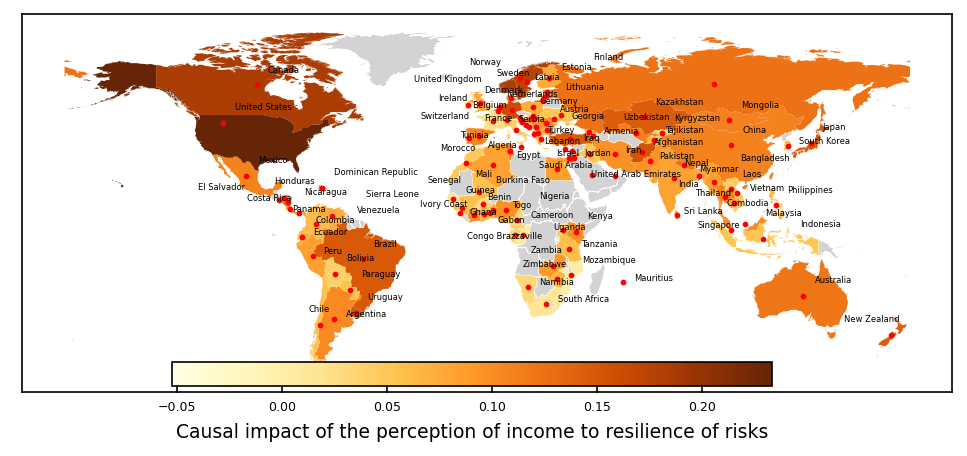

In [56]:
cmap = mpl.cm.YlOrBr
# Set the size of the plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

# Plot the base map in grey color
regions.plot(ax=ax, facecolor='lightgrey', edgecolor='white', linewidth=0.5)

# Remove grids
ax.grid(False)

# Risk frequency
risk_plot = Mean_country_gpd.plot(ax=ax, column='CATE_resilience', cmap=cmap, legend=False)

# Create a colorbar within the main graph and make it horizontal
norm = plt.Normalize(Mean_country_gpd['CATE_resilience'].min(), Mean_country_gpd['CATE_resilience'].max())
cbar_ax = fig.add_axes([0.25, 0.35, 0.5, 0.02])  # Adjust the position and size of the colorbar
cbar = mcb.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.ax.set_xlabel('Causal impact of the perception of income to resilience of risks',fontsize = 9)
cbar.ax.tick_params(labelsize=6)

# Add markers and store annotations in a list
texts = []
for idx, row in Mean_country_gpd.iterrows():
    ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y, s=3, color='red')
    if (row['region_category'] != 'Eastern Europe') &  (row['region_category'] != 'Southern Europe') :
        texts.append(ax.annotate(row['Country'], xy=(row.geometry.centroid.x, row.geometry.centroid.y), xytext=(5, 5), textcoords='offset points', fontsize=4, color='black'))

# Optimize annotation positions to minimize overlaps
adjust_text(texts, ax=ax,force_text=0.05)

# Hide the x-axis and y-axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
#plt.tight_layout()
plt.savefig('../Figures/CATE_resilience.pdf',bbox_inches='tight')
# Show the plot
plt.show()

## Step 3: Now let's focus on the Resilience index

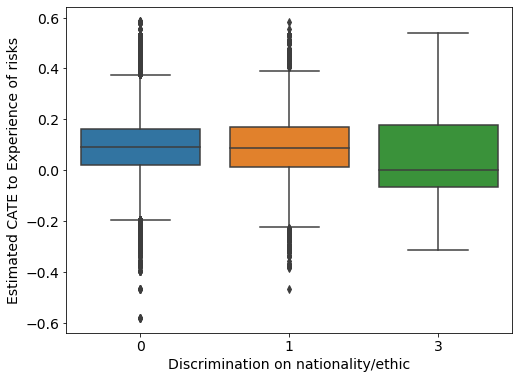

In [57]:
# Assume that cate_estimates is a numpy array or pandas Series of the estimated CATE for each individual
# and df2 is your DataFrame that includes a column 'IncomeBracket' that you want to inspect

plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y=df['CATE_resilience'], x=df['Dis_ethic'])
plt.xlabel('Discrimination on nationality/ethic')
plt.ylabel('Estimated CATE to Experience of risks')
plt.show()


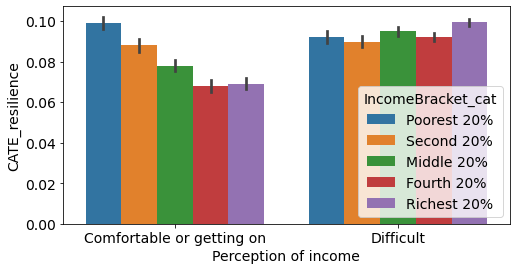

In [34]:


plt.figure(figsize=(8,4))
g= sns.barplot(x='IncomePerc_binary', y='CATE_resilience', hue='IncomeBracket_cat', data=df)
plt.xlabel('Perception of income')
g.set_xticklabels(['Comfortable or getting on','Difficult'])
#plt.legend(title='Income bracket', loc='upper left', labels=['Poorest 20%','Second 20%','Middle 20%','Fourth 20%','Richest 20%'])
plt.show(g)
#plt.title('Violin plot of Outcome by Variable1 and Variable2')
plt.show()




posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


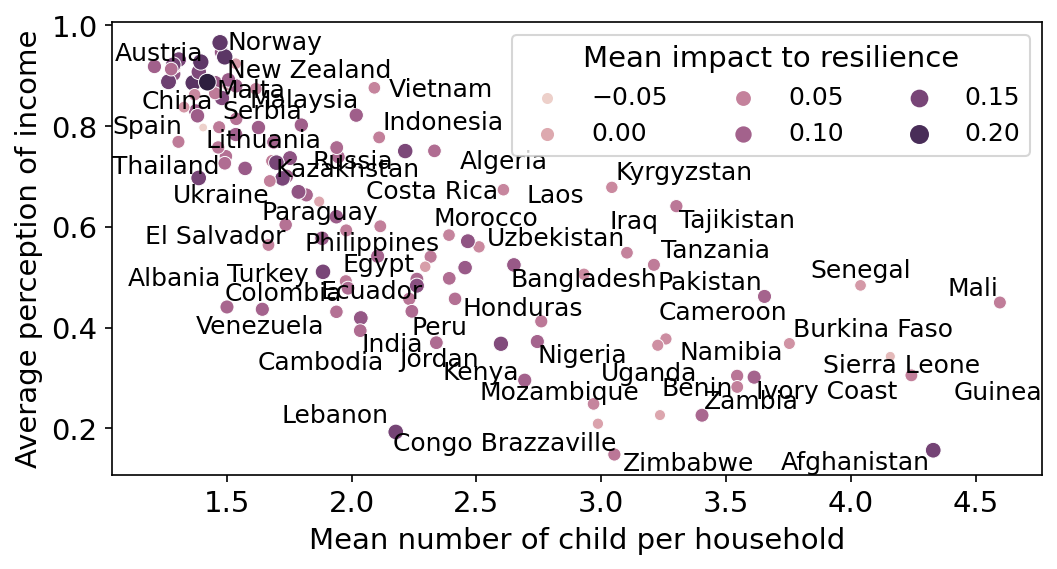

In [75]:

df['Child']=df['Child'].astype('uint8')

# List of countries to label

#countries_to_label = ['United Kingdom','Malaysia','Albania','Mongolia','Macedonia','Zambia','Nigeria','Benin','Burkina Faso','Togo','Cameroon','Mali','Finland','Egypt','Latvia','Kazakhstan','Paraguay','United States','Germany','Spain','Afganistan','Thailan','Algeria','Peru','Indonesia','Serbia','Ukraine','Colombia','Uzbekistan','Guinea','Mali','Dominican Republic','Venezuela','Saudi Arabia','Namibia','Thailand','El Salvador','Paraguay','New Zealand','Australia','United States','China','Mexico','Israel','Slovakia','Vietnam','Iraq','Nigeria','Ghana','Namibia','Sri Lanka','Iran','Cambodia','Kenya','Ivory Coast','Brazil','South Africa','Togo','China','Mexico','Laos','Sweden','France','Japan','Mauritius']
#countries_to_label = Mean_country.Country.unique()
countries_to_remove = ['Gabon','Croatia','Togo','France','Iceland','Denmark','Ireland','Mauritius','Tunisia','Myanmar','Netherlands','Portugal','Belgium','Poland','Singapore','United Kingdom','Mongolia','Estonia','Ghana','North Macedonia','Dominican Republic','Nicaragua','Panama','South Africa','Phillipines','Iran','Moldova','Georgia','Hungary','Nepal','Gabon','Bolivia','Mexico','Armenia','Uruguay','Bulgaria','Cyprus','Sweden','Japan','Australia','United States','Romania','Latvia','Israel','Canada','Bosnia Herzegovina','Italy','South Korea','Sri Lanka','Armenia','Argentina','Switzerland','Germany','Slovakia','Slovenia','Finland','Chile','Brazil','Greece']
fig, ax = plt.subplots(figsize=(8, 4), dpi=150)

g = sns.scatterplot(
    data=Mean_country,
    x='Child',
    y='IncomePerc_binary',
    hue='CATE_resilience',
    size = 'CATE_resilience'
)

texts=[]
# Add country names as labels to the points
for i, row in Mean_country.iterrows():
    if row['Country'] not in countries_to_remove:
        texts.append(plt.text(row['Child'], row['IncomePerc_binary'], row['Country'], fontsize=12))

# Set x and y axis labels
ax.set_xlabel('Mean number of child per household', fontsize=14)
ax.set_ylabel('Average perception of income', fontsize=14)

adjust_text(texts, ax=ax,force_text=0.01)

g.legend(loc='upper right',ncol=3, title="Mean impact to resilience", fontsize=12)



fig.savefig('../Figures/CATE_child_income.pdf',bbox_inches='tight')

# Display the plot
plt.show()

In [39]:
median_resilience = df['Resilience_ind'].median()
df['resilience_bins'] = df['Resilience_ind'].apply(lambda x: 'High' if x > median_resilience else 'Low').astype('category')

df_USA = df[df.Country=='United States']
df_SA = df[df.Country=='South Africa']


In [42]:
df= df_USA
#import plotly.graph_objects as go
#df['resilience_bins'] = pd.qcut(df['Resilience_ind'], q=2, labels=['Low', 'High'])


labels=['Comfortable','Difficult']
# Create new dataframe column with the labels instead of numbers
df["IncomePerc_binary_cat"] = df["IncomePerc_binary"].map(dict(zip([1,0], labels)))

# Transform the variables to string to avoid potential issues
df['Child_str'] = df['Child'].astype(str)
df['IncomeBracket_str'] = df['IncomeBracket_cat'].astype(str)
df['IncomePerc_str'] = df['IncomePerc_binary_cat'].astype(str)
df['resilience_bins_str'] = df['resilience_bins'].astype(str)

# Define the node labels
labels = sorted(list(df['Child_str'].unique())) + sorted(list(df['IncomeBracket_str'].unique())) + sorted(list(df['IncomePerc_str'].unique())) + sorted(list(df['resilience_bins_str'].unique()))

# Define the source, target, and value arrays
source = []
target = []
value = []

for i in df['Child_str'].unique():
    for j in df[df['Child_str']==i]['IncomeBracket_str'].unique():
        source.append(labels.index(i))
        target.append(labels.index(j))
        value.append(len(df[(df['Child_str']==i) & (df['IncomeBracket_str']==j)]))

for i in df['IncomeBracket_str'].unique():
    for j in df[df['IncomeBracket_str']==i]['IncomePerc_str'].unique():
        source.append(labels.index(i))
        target.append(labels.index(str(j)))
        value.append(len(df[(df['IncomeBracket_str']==i) & (df['IncomePerc_str']==j)]))

for i in df['IncomePerc_str'].unique():
    for j in df[df['IncomePerc_str']==i]['resilience_bins_str'].unique():
        source.append(labels.index(i))
        target.append(labels.index(j))
        value.append(len(df[(df['IncomePerc_str']==i) & (df['resilience_bins_str']==j)]))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.show()
fig.write_image("../Figures/sankey_diagram_USA.pdf")

In [44]:
df= df_SA
#import plotly.graph_objects as go
#df['resilience_bins'] = pd.qcut(df['Resilience_ind'], q=2, labels=['Low', 'High'])


labels=['Comfortable','Difficult']
# Create new dataframe column with the labels instead of numbers
df["IncomePerc_binary_cat"] = df["IncomePerc_binary"].map(dict(zip([1,0], labels)))

# Transform the variables to string to avoid potential issues
df['Child_str'] = df['Child'].astype(str)
df['IncomeBracket_str'] = df['IncomeBracket_cat'].astype(str)
df['IncomePerc_str'] = df['IncomePerc_binary_cat'].astype(str)
df['resilience_bins_str'] = df['resilience_bins'].astype(str)

# Define the node labels
labels = sorted(list(df['Child_str'].unique())) + sorted(list(df['IncomeBracket_str'].unique())) + sorted(list(df['IncomePerc_str'].unique())) + sorted(list(df['resilience_bins_str'].unique()))

# Define the source, target, and value arrays
source = []
target = []
value = []

for i in df['Child_str'].unique():
    for j in df[df['Child_str']==i]['IncomeBracket_str'].unique():
        source.append(labels.index(i))
        target.append(labels.index(j))
        value.append(len(df[(df['Child_str']==i) & (df['IncomeBracket_str']==j)]))

for i in df['IncomeBracket_str'].unique():
    for j in df[df['IncomeBracket_str']==i]['IncomePerc_str'].unique():
        source.append(labels.index(i))
        target.append(labels.index(str(j)))
        value.append(len(df[(df['IncomeBracket_str']==i) & (df['IncomePerc_str']==j)]))

for i in df['IncomePerc_str'].unique():
    for j in df[df['IncomePerc_str']==i]['resilience_bins_str'].unique():
        source.append(labels.index(i))
        target.append(labels.index(j))
        value.append(len(df[(df['IncomePerc_str']==i) & (df['resilience_bins_str']==j)]))

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.show()
fig.write_image("../Figures/sankey_diagram_SA.pdf")
